`pip install pyyaml`

`pip install xarray`

## Single File Example from OOI Raw Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import xarray as xr
import yaml

In [2]:
def load_hdr(hdr_filepath: str) -> dict:
    with open(hdr_fp,'r') as _file:
        hdr_data = yaml.safe_load(_file)
    return hdr_data

def load_adc(adc_filepath: str, file_header: list | str) -> xr.Dataset:
    if isinstance(file_header, str): 
        file_header = file_header.split(',')
    file_header = [col.replace('#','') for col in file_header] # Replace any hashes.
    file_header = [col.replace(' ','') for col in file_header] 
    _df = pd.read_csv(adc_filepath, names = file_header)
    _df = _df.rename(columns = {'trigger': 'trigger_number'})
    ds = _df.to_xarray()
    return ds

def subset_roi(file_bytes: bytearray, start_byte_index: int, roi_width: int, roi_height: int) -> bytearray:
    roi_byte_length = roi_width * roi_height
    roi_bytes = bytes(rfb[start_byte_index: start_byte_index + roi_byte_length])
    return roi_bytes

def roi2img(roi_filepath:str, adc_roi: xr.Dataset, save_filepath: str | None, autosave: bool =  False):
    if adc_roi.index.size > 1:
        raise ValueError
    else:
        with open(roi_filepath,'rb') as _file:
            rfb = bytearray(_file.read())
        roi_byte_start = int(adc_roi.StartByte)
        roi_width = int(adc_roi.RoiWidth)
        roi_height = int(adc_roi.RoiHeight)
        roi_byte_length = roi_width * roi_height
        
        roi_bytes = bytes(rfb[roi_byte_start: roi_byte_start + roi_byte_length])
        
        _img = Image.frombytes('L', (roi_width, roi_height), roi_bytes)

        if autosave is True:
            _img.save(save_filepath)

        return _img

In [3]:
__user_dir = os.path.expanduser('~')
roi_fp = os.path.join(__user_dir, r'ooi/uncabled/CP10CNSM/R00001/cg_data/dcl27/plims/2024/202407/D20240702T082459_IFCB199.roi')
hdr_fp = os.path.join(__user_dir, r'ooi/uncabled/CP10CNSM/R00001/cg_data/dcl27/plims/2024/202407/D20240702T082459_IFCB199.hdr')
adc_fp = os.path.join(__user_dir, r'ooi/uncabled/CP10CNSM/R00001/cg_data/dcl27/plims/2024/202407/D20240702T082459_IFCB199.adc')

In [4]:
hdr = load_hdr(hdr_fp)
adc_file_format = hdr['ADCFileFormat']  # Parse out file format from accompanying ADC file.

adc = load_adc(adc_fp,adc_file_format)
for k,v in hdr.items():
    adc.attrs[k] = v

adc_roi = adc.sel(index = 18) # Select roi by line index within adc file
img = roi2img(roi_fp, adc_roi, save_filepath = None, autosave = False)

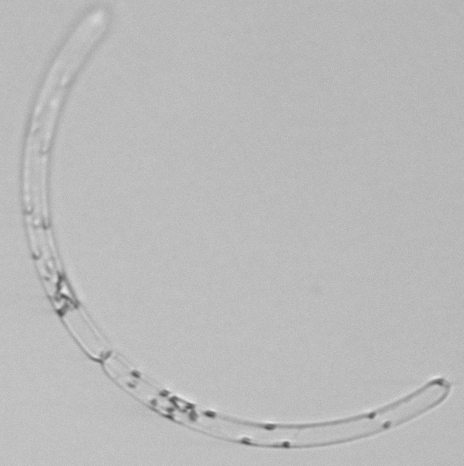

In [5]:
img

In [6]:
adc_roi

<xarray.Dataset> Size: 200B
Dimensions:         ()
Coordinates:
    index           int64 8B 18
Data variables: (12/24)
    trigger_number  int64 8B 19
    ADCtime         float64 8B 52.62
    PMTA            float64 8B 0.0146
    PMTB            float64 8B 0.1441
    PMTC            float64 8B 0.007503
    PMTD            float64 8B 0.00889
    ...              ...
    ComparatorOut   int64 8B 0
    StartPoint      int64 8B 0
    SignalLength    int64 8B 0
    Status          int64 8B 0
    RunTime         float64 8B 52.64
    InhibitTime     float64 8B 1.602
Attributes: (12/132)
    SoftwareVersion:                                   2.5.0.0
    AnalogFirmware:                                    45
    HousekeepingFirmware:                              33
    sampleNumber:                                      1
    sampleType:                                        Normal
    triggerCount:                                      493
    ...                                                ...
    GPSFeed:                                           0
    PhytoArmDataSource:                                0
    ServerAsAdmin:                                     False
    HostAsAdmin:                                       False
    UpdateServer:                                      http://mclanelabs.dynd...
    TestMode:                                          False